In [2]:
# Autor: Daniel Pinto
# Problemas de grafos
# Fecha: 2021/10/11 YYYY/MM/DD
from typing import List, TypeVar, Tuple, Any, Callable, Optional, Generic, Dict
from hypothesis import given, strategies as st
from IPython.display import Markdown, display
from dataclasses import dataclass, field
from __future__ import annotations 
from copy import deepcopy
from collections.abc import  Iterable
import graphviz as gv
from abc import ABCMeta, abstractmethod
from math import inf

def display_(s : str) -> None:
    '''
    A way to display strings with markdown 
    in jupyter.
    '''
    display(
        Markdown(s)
    )


SUCCESS_COLOR = '#4BB543'
ERROR_COLOR   = '#B00020'

def color_text(s : str, color : str =SUCCESS_COLOR ) -> str:
    return f"<span style='color:{color}'> {s} </span>."


a      = TypeVar('a')
b      = TypeVar('b')
c      = TypeVar('c')
T      = TypeVar('T')

In [3]:
class AGraph(Generic[T], metaclass=ABCMeta):
    @abstractmethod
    def add_vertex(self,v : T) -> None:
        raise NotImplementedError

    @abstractmethod
    def add_edge(self,vs : Tuple[T,T]) -> None:
        raise NotImplementedError

    
    def add_vertices(self, vertices : Iterable[T]) -> None:
        for vertex in vertices:
            self.add_vertex(vertex)

    
    def add_edges(self, edges : Iterable[Tuple[T,T]]) -> None:
        for edge in edges:
            self.add_edge(edge)

    @abstractmethod
    def succs(self, v : T) -> List[T]:
        raise NotImplementedError

    @abstractmethod
    def preds(self, v : T) -> List[T]:
        raise NotImplementedError
    
    @abstractmethod
    def get_randV(self) -> T:
        raise NotImplementedError

    @abstractmethod
    def get_Vertices(self) -> set[T]:
        raise NotImplementedError

    @abstractmethod
    def get_Edges(self) -> set[Tuple[T,T]]:
        raise NotImplementedError

    
    def BFS_levels(self, iv : Optional[T] = None) -> Iterable[List[T]]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True



        while bool(mem) and change:
            change = False
            yield current
            for v in current:
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    def BFS(self, iv : Optional[T] = None) -> Iterable[T]:
        if iv is None:
            try:
                current : List[T] = [self.get_randV()]
            except:
                return
        else:
            current : List[T] = [iv]
        
        mem : set[T] = self.get_Vertices()
        mem.discard(current[0])
        next_v : List[T] = []
        change : bool = True

        while bool(mem) and change:
            change = False
            for v in current:
                yield v
                mem.discard(v)
                for succ in self.succs(v):
                    if succ in mem:
                        change = True
                        next_v.append(succ)
                        mem.discard(succ)
            current = next_v
            next_v  = []

    
    def DFS(self, iv : Optional[T] = None) -> Iterable[T]:

        if iv is None:
            try:
                iv  = self.get_randV()
            except:
                return


        mem : set[T] = self.get_Vertices()
        def DFS_(v : T) -> Iterable[T] :
            mem.discard(v)
            yield v
            if not mem:
                return

            for succ in self.succs(v):
                # si el sucesor aun no se ha visitado
                if succ in mem:
                    for s in DFS_(succ):
                        yield s

        return DFS_(iv)

    
    def toPic(self) -> gv.Graph:
        raise NotImplementedError


@dataclass
class Graph(Generic[T],AGraph[T]):
    _Map         : Dict[T,int]   
    _adj_l       : List[List[T]]
    _i           : int 
    _is_directed : bool
    _is_weighted : bool
    _invMap      : Dict[int,T]
    _cost        : Dict[Tuple[T,T],float]

    def __init__(self, is_directed : bool = False, is_weighted : bool = False) -> None:
        self._Map         = {}
        self._invMap      = {}
        self._adj_l       = []
        self._i           = 0
        self._cost        = {}
        self._is_directed = is_directed
        self._is_weighted = is_weighted

    def get_cost(self,vw : Tuple[T,T]) -> Optional[float]:
        if vw not in self._cost:
            return None
        return self._cost[vw]
    
    def add_vertex(self,v : T) -> None:
        if v in self._Map:
            return
        
        self._Map[v] = self._i
        self._adj_l.append([])
        self._invMap[self._i] = v
        self._i    += 1
    
    def _add_edge_dir(self, vs: Tuple[T, T]) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        
        # a -> [a,b,c]

        i : int = self._Map[v]
        if s not in self._adj_l[i]:
            self._adj_l[i].append(s)
    
    def _add_edge_undir(self, vs: Tuple[T, T]) -> None:
        sv = (vs[1],vs[0])
        # (v,s)
        # (s,v)
        self._add_edge_dir(vs)
        self._add_edge_dir(sv)
    
    def _add_edge_cost_dir(self, vs: Tuple[T, T], cost : float) -> None:
        (v,s) = vs
        if (v not in self._Map) or (s not in self._Map):
            return
        i : int = self._Map[v]
        if s in self._adj_l[i]:
            self._cost[vs] = cost
    
    def _add_edge_cost_undir(self, vs: Tuple[T, T], cost : float) -> None:
        sv = (vs[1],vs[0])
        self._add_edge_cost_dir(vs, cost)
        self._add_edge_cost_dir(sv, cost)


    def add_edge(self,vs : Tuple[T,T], cost : float = 0) -> None:
        if self._is_directed:
            self._add_edge_dir(vs)
        else:
            self._add_edge_undir(vs)
        
        if self._is_weighted:
            self._add_edge_cost_dir(vs,cost)
        else:
            self._add_edge_cost_undir(vs,cost)

    def add_cost_edges(self, edges : Iterable[Tuple[T,T,float]]) -> None:
        for (v,s,c) in edges:
            self.add_edge((v,s),c)
            if not self._is_directed:
                self.add_edge((s,v),c)


    def succs(self, v : T) -> List[T]:
        i : int = self._Map[v]
        return self._adj_l[i]
    
    def preds(self, v : T) -> List[T]:
        # 
        if not self._is_directed:
            return self.succs(v)
        
        res : List[T] = []
        for i in range(self._i):
            if v in self._adj_l[i]:
                res.append(self._invMap[i])
        return res

    def get_Vertices(self) -> set[T]:
        return set(self._Map.keys())
    
    def get_Edges(self) -> set[Tuple[T, T]]:
        s : set[Tuple[T, T]] = set()
        for v in self.get_Vertices():
            for v_ in self._adj_l[self._Map[v]]:
                if ((v_,v) in s) and (not self._is_directed):
                    pass
                else:
                    s.add((v,v_))

        return s

    def get_randV(self) -> T:
        from random import randint
        try:
            n : int = randint(0,len(self._adj_l)-1)
        except:
            raise ValueError
        
        return self._invMap[n]


    def _toPicDir(self) -> gv.Graph:
        g : gv.Graph = gv.Digraph()
        if not self._Map:
            return g

        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)

        return g
    
    def _toPicUnDir(self) -> gv.Graph:
        g : gv.Graph = gv.Graph()
        if not self._Map:
            return g
        
        for v in self.get_Vertices():
            g.node(str(self._Map[v]), str(v))
        
        for (v,v_) in self.get_Edges():
            if self._is_weighted:
                label : Optional[str] = str(self._cost[(v,v_)])
            else:
                label = None 

            i_v  : str = str(self._Map[v])
            i_v_ : str = str(self._Map[v_])
            g.edge(i_v,i_v_,label=label)
        
        return g

    def toPic(self) -> gv.Graph:
        if self._is_directed:
            return self._toPicDir()
        else:
            return self._toPicUnDir()
    
    def __deepcopy__(self) -> Graph[T]:
        g : Graph[T]   = Graph()
        g._Map         = deepcopy(self._Map)
        g._adj_l       = deepcopy(self._adj_l)
        g._i           = deepcopy(self._i)
        g._is_directed = deepcopy(self._is_directed)
        g._is_weighted = deepcopy(self._is_weighted)
        g._invMap      = deepcopy(self._invMap)
        g._cost        = deepcopy(self._cost)

        return g






In [4]:
@dataclass
class Heap(Generic[T,a]):
    arr         : List[Tuple[a,T]]  
    assocs      : Dict[T,List[int]] 
    is_max_heap : bool          
    lt          : Callable[[a,a],bool]   
    gt          : Callable[[a,a],bool]   

    def __init__(self, is_max_heap : bool) -> None:
        self.arr         = []
        self.assocs      = {}
        self.is_max_heap = is_max_heap
        self.lt          = (lambda x,y: x<y ) if is_max_heap else (lambda x,y: x>y )
        self.gt          = (lambda x,y: x>y ) if is_max_heap else (lambda x,y: x<y )


    def up_heapify(self, i : int):
        p : int = (i-1) // 2
        while(True):
            if (p<0) or self.gt(self.arr[p][0], self.arr[i][0]):
                return
            
            # p : 3
            # p_val : [0,3,5]
            p_val   : T   = self.arr[p][1]
            i_val   : T   = self.arr[i][1]
            p_index : int = self.assocs[p_val].index(p)
            i_index : int = self.assocs[i_val].index(i)

            self.assocs[p_val][p_index] = i
            self.assocs[i_val][i_index] = p
            
            self.arr[p], self.arr[i] = self.arr[i], self.arr[p]

            i = p
            p = (p-1) // 2

    def down_heapify(self,i : int):
        l : int = (2*i) + 1
        r : int = (2*i) + 2
        largest : int = -1
        n : int = len(self.arr) - 1
        
        if l>n and r>n:
            return
        if r>n:
            r=l
        if l>n:
            l=r

        if self.gt(self.arr[i][0], self.arr[l][0] ) and self.gt(self.arr[i][0], self.arr[r][0]):
            return


        if self.gt(self.arr[l][0], self.arr[r][0]):
            largest = l
        else:
            largest = r
        

        largest_val   : T   = self.arr[largest][1]
        i_val         : T   = self.arr[i][1]
        largest_index : int = self.assocs[largest_val].index(largest)
        i_index : int = self.assocs[i_val].index(i)

        self.assocs[largest_val][largest_index] = i
        self.assocs[i_val][i_index] = largest

        self.arr[largest], self.arr[i] = self.arr[i], self.arr[largest]

        self.down_heapify(largest)

    def extract_root_(self) -> Optional[T]:
        if self.arr == []:
            return None
        
        root : T = self.arr[0][1]
        self.arr[0], self.arr[-1] = self.arr[-1], self.arr[0]

        new_root : T = self.arr[0][1]
        n : int = len(self.arr) - 1
        n_index : int = self.assocs[new_root].index(n) 
        self.assocs[new_root][n_index] = 0 


        self.arr.pop()

        self.down_heapify(0)
        
        return root
        


    def insert_(self, x:T, priority : a):
        self.arr.append((priority,x))
        n : int = len(self.arr) - 1
        if x in self.assocs:
            self.assocs[x].append(n)
        else:
            self.assocs[x] = [n]

        self.up_heapify(n)



    def push_pop(self,x : T, priority : a) -> T:
        if self.arr == []:
            return x
        if self.gt(priority,  self.arr[0][0]):
            return x
        root : T = self.arr[0][1]
        if self.assocs[root] == []:
            self.assocs.pop(root)
        else:
            self.assocs[root].remove(0)
        if x in self.assocs:
            self.assocs[x].append(0)
        else:
            self.assocs[x] = [0]
        self.arr[0] = (priority,x)
        self.down_heapify(0) 

        return root

    def modify_val(self, x:T, priority : a, f : Callable[[T,a,a],a] = lambda val,new,old: new):
        if x not in self.assocs:
            return
        pos_x = self.assocs[x][0]

        (p,v) = self.arr[pos_x]
        p_    = f(x,priority,p)

        self.arr[pos_x] = (p_,v)
        
        self.down_heapify(pos_x)
        self.up_heapify(pos_x)

    def toPic(self) -> gv.Digraph:
        dot : gv.Digraph = gv.Digraph(comment='Heap')
        current : int = 0
        if self.arr == []:
            return dot
        dot.node(str(0),str(self.arr[0]))
        for i in range(1,len(self.arr)):
            dot.node(str(i),str(self.arr[i]))
            dot.edge(str((i-1)//2),str(i))
        return dot 

def randomHeap(size : int = 10 ) -> Heap[int,int]:
    from random import randint
    acc  : List[int] = []
    heap : Heap[int,int] = Heap(is_max_heap=False) 
    for _ in range(size):
        n = randint(-size,size)
        acc.append(n)
        heap.insert_(n,n)
    
    print(acc)
    return heap




h : Heap[int,int] = randomHeap()        
#h.toPic().view(filename="name.gv",cleanup=True,)
#print(h.extract_root())
print(h.assocs)
print(h.arr)
h.toPic()



@dataclass(order=True)
class PrioritizedItem(Generic[T]):
    priority: float
    item: Any= field(compare=False)

    def __eq__(self, o: object) -> bool:
        if not isinstance(o,PrioritizedItem):
            return False
        
        return self.item == o.item

    def __hash__(self) -> int:
        return self.item.__hash__()


t1 = PrioritizedItem(1,'a') 
t2 = PrioritizedItem(2,'b')
d = {}
d[t1] = 10
d[t2] = 20

print(d[PrioritizedItem(10,'a')])



[-3, -8, -9, 10, 9, -8, -9, -4, 3, 7]
{-3: [3], -8: [5, 6], -9: [2, 0], 10: [7], 9: [9], -4: [1], 3: [8], 7: [4]}
[(-9, -9), (-4, -4), (-9, -9), (-3, -3), (7, 7), (-8, -8), (-8, -8), (10, 10), (3, 3), (9, 9)]
10


# Parallel Courses 


You are given an integer `n`, which indicates that there are `n` courses labeled from `1` to `n`. You are also given an array `relations` where `relations[i] = [prevCoursei, nextCoursei]`, representing a prerequisite relationship between course `prevCoursei` and course `nextCoursei`: course `prevCoursei` has to be taken before course `nextCoursei`. Also, you are given the integer k.

In one semester, you can take **at most** `k` courses as long as you have taken all the prerequisites in the **previous** semester for the courses you are taking.

Return the **minimum** number of semesters needed to take all courses. The testcases will be generated such that it is possible to take every course.


## Examples: 

<center>

![''](./Images/parallel_courses.png)

</center>

```
Input:
    n = 4, 
    dependencies = [[2,1],[3,1],[1,4]], k = 2
    
Output: 3 

Explanation: The figure above represents the given graph.
In the first semester, you can take courses 2 and 3.
In the second semester, you can take course 1.
In the third semester, you can take course 4.

```

<center>

![''](./Images/parallel_courses_2.png)

</center>

```
Input: 
    n = 5, 
    dependencies = [[2,1],[3,1],[4,1],[1,5]], k = 2

Output: 4 
Explanation: The figure above represents the given graph.
In the first semester, you can take courses 2 and 3 only since you cannot take more than two per semester.
In the second semester, you can take course 4.
In the third semester, you can take course 1.
In the fourth semester, you can take course 5.
```




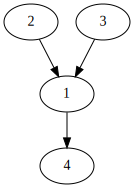

3


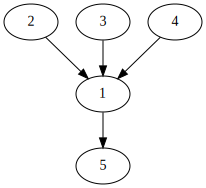

4


In [5]:
# sol

@dataclass
class DSet(Generic[T]):
    node   : T
    parent : Optional[DSet[T]]
    size   : int


    def __init__(self,node : T):
        self.node   = node
        self.parent = None
        self.size   = 1

    def find_repr(self) -> T:
        parent : Optional[DSet[T]] = self.parent

        while (parent is not None):
            self.parent = parent
            parent      = parent.parent
        
        if self.parent is not None:
            return self.parent.node
        else:
            return self.node
        

    def union(self,y : DSet[T]):
        x_repr : T = self.find_repr()
        y_repr : T = y.find_repr()

        if self.parent is not None:
            x_root : DSet[T] = self.parent
        else:
            x_root : DSet[T] = self
        
        if y.parent is not None:
            y_root : DSet[T] = y.parent
        else:
            y_root : DSet[T] = y
        

        if x_repr == y_repr:
            return


        if x_root.size > y_root.size:
            y_root.parent = x_root
            x_root.size  += y_root.size
        else:
            x_root.parent = y_root
            y_root.size  += x_root.size

    def __repr__(self) -> str:
        val : str = str(self.node)
        aux : Optional[DSet[T]] = self.parent
        while aux is not None:
            val += " -> " + str(aux.node)
            aux  = aux.parent

        return val


def semesters(G : Graph[T], k : int) -> int:

    source_vertices : set[T] = G.get_Vertices()
    sink_vertices   : set[T] = G.get_Vertices()
    has_succ        : bool   = False
    i               : int    = 0
    j               : int    = 0

    vs : set[T] = G.get_Vertices()
    c : Dict[T,float]         = {}
    queue : Heap[T,float]     = Heap(is_max_heap=False)


    for v in vs:
        c[v] = 0
    
    for v in vs:
        has_succ = False
        for succ in G.succs(v):
            has_succ = True 
            source_vertices.discard(succ)
            c[succ] += 1
        if has_succ:
            sink_vertices.discard(v)

    for v in vs:
        queue.insert_(v,c[v])

    #display(queue.toPic())

    display(G.toPic())

    prev : T = queue.arr[0][1]
    while (w := queue.extract_root_()) is not None:
        j += 1
        if (w in G.succs(prev)) or (j==k):
            j  = 1
            i += 1 
        prev = w
        for v in G.succs(w):
            c[v] = c[v] - 1
            queue.modify_val(v,c[v])


    return i


g : Graph[int] = Graph(is_directed=True,is_weighted=False)
g.add_vertices([1,2,3,4])
g.add_edges([(2,1),(3,1),(1,4)])

print(semesters(g,2))

g : Graph[int] = Graph(is_directed=True,is_weighted=False)
g.add_vertices([1,2,3,4,5])
g.add_edges([(2,1),(3,1),(4,1),(1,5)])

print(semesters(g,2))


#  Minimum Cost to Reach Destination in Time

There is a country of `n` cities numbered from `0` to `n - 1` where **all the cities are connected** by bi-directional roads. The roads are represented as a 2D integer array edges where `edges[i] = [xi, yi, timei]` denotes a road between cities `xi` and `yi` that takes `timei` minutes to travel. There may be multiple roads of differing travel times connecting the same two cities, but no road connects a city to itself.

Each time you pass through a city, you must pay a passing fee. This is represented as a **0-indexed** integer array `passingFees` of length `n` where `passingFees[j]` is the amount of dollars you must pay when you pass through city `j`.

In the beginning, you are at city `0` and want to reach city `n - 1` in `maxTime` **minutes or less**. The **cost** of your journey is the **summation of passing fees** for each city that you passed through at some moment of your journey (**including** the source and destination cities).

Given `maxTime`, `edges`, and `passingFees`, return **the minimum cost** to complete your journey, or `-1` if you cannot complete it within **maxTime** minutes.

## Example

<center>

![''](./Images/min_cost.png)

</center>

```
Input: 
    maxTime = 30, 
    edges = [[0,1,10],[1,2,10],[2,5,10],[0,3,1],[3,4,10],[4,5,15]], passingFees = [5,1,2,20,20,3]

Output: 11
Explanation: The path to take is 0 -> 1 -> 2 -> 5, which takes 30 minutes and has $11 worth of passing fees.
```



In [6]:
# sol


    
def min_cost_visualitaztion(G : Graph[T], c_acc : Dict[T,float]) -> None:
    if G._is_directed:
        g : gv.Graph = gv.Digraph()
    else:
        g : gv.Graph = gv.Graph()
    if not G._Map:
        return g

    for v in G.get_Vertices():
        g.node(str(G._Map[v]), f"{v}: {c_acc[v]}" )
    
    for (v,v_) in G.get_Edges():
        if G._is_weighted:
            label : Optional[str] = str(G._cost[(v,v_)])
        else:
            label = None 

        i_v  : str = str(G._Map[v])
        i_v_ : str = str(G._Map[v_])
        g.edge(i_v,i_v_,label=label)

    display(g)
    input()


#   1    -5
# 1 -> 2 -> 1 
# -4
# -8

def Bellman(times : List[Tuple[int,int,float]], maxTime : float, passingFees : List[float]) -> List[int]:
    
    edges  : List[Tuple[int,int,float]] = []
    vs     : set[int]                   = set([i for i in range(len(passingFees))])
    tiempo : Dict[Tuple[int,int],float] = {}

    for (v,w,t) in times:
        edges.append((v,w,passingFees[v]))
        tiempo[(v,w)] = t
        tiempo[(w,v)] = t
    


    G : Graph[int]                   = Graph(is_directed=False,is_weighted=True)
    G.add_vertices(vs)
    G.add_cost_edges(edges)
    costo  : Dict[int,float]         = {}
    tiempo_acc : Dict[int,float]     = {}
    preds  : Dict[int,Optional[int]] = {}
    n_vs   : int                     = len(vs)
    for v in vs:
        costo[v]      = inf
        tiempo_acc[v] = 0
        preds[v]      = None 

    costo[0]      = 0
    i      : int  = 1
    cambio : bool = True 

    while (i<=n_vs) and cambio:
        cambio = False
        #min_cost_visualitaztion(G,costo)
        # (v,w) -> (w,v)
        for (v,w) in G.get_Edges():
            edge_cost = G.get_cost((v,w))
            if edge_cost is None:
                edge_cost = G.get_cost((w,v))
            
            assert(edge_cost is not None)

            if (costo[w] > costo[v] + edge_cost ) and (tiempo_acc[v] + tiempo[(v,w)] <= maxTime):
                costo[w] = costo[v] + edge_cost
                preds[w] = v
                tiempo_acc[w] = tiempo_acc[v] +  tiempo[(v,w)]
                cambio   = True
            elif (costo[v] > costo[w] + edge_cost ) and (tiempo_acc[w] + tiempo[(v,w)] <= maxTime):
                costo[v] = costo[w] + edge_cost 
                preds[v] = w
                tiempo_acc[v] = tiempo_acc[w] +  tiempo[(v,w)]
                cambio   = True
        i += 1
    

    res : List[int] = [n_vs-1]
    pred            = n_vs-1
    while (pred := preds[pred]) is not None:
        res.append(pred)

    res.reverse()

    return res

print(Bellman([(0,1,10),(0,3,1),(1,2,10),(3,4,10),(2,5,10),(4,5,15)], 29, [5,1,2,20,20,3]))
# 0 3 4 5
print(Bellman([(0,1,10),(0,3,1),(1,2,10),(3,4,10),(2,5,10),(4,5,15)], 30, [5,1,2,20,20,3]))
# 0 1 2 5





[0, 3, 4, 5]
[0, 1, 2, 5]


# Number of Restricted Paths From First to Last Node

There is an undirected weighted connected graph. You are given a positive integer `n` which denotes that the graph has `n` nodes labeled from `1` to `n`, and an array `edges` where each `edges[i] = [ui, vi, weighti]` denotes that there is an edge between nodes `ui` and `vi` with weight equal to `weighti`.

A path from node `start` to node `end` is a sequence of nodes `[z0, z1, z2, ..., zk]` such that `z0 = start` and `zk = end` and there is an edge between `zi` and `zi+1` where `0 <= i <= k-1`.

The distance of a path is the sum of the weights on the edges of the path. Let `distanceToLastNode(x)` denote the shortest distance of a path between node `n` and node `x`. A **restricted path** is a path that also satisfies that `distanceToLastNode(zi) > distanceToLastNode(zi+1)` where `0 <= i <= k-1`.

Return the number of restricted paths from node `1` to node `n`. Since that number may be too large, return it **modulo** `10^9 + 7`.

<center>

![''](./Images/camino[i].png)

</center>

```
Input: 
    n = 5, 
    edges = [[1,2,3],[1,3,3],[2,3,1],[1,4,2],[5,2,2],[3,5,1],[5,4,10]]

Output: 3

Explanation: Each circle contains the node number in black and its distanceToLastNode value in blue. The three restricted paths are:
1) 1 --> 2 --> 5
2) 1 --> 2 --> 3 --> 5
3) 1 --> 3 --> 5
```

<center>

![''](./Images/path2.png)

</center>

```
Input: 
    n = 7, 
    edges = [[1,3,1],[4,1,2],[7,3,4],[2,5,3],[5,6,1],[6,7,2],[7,5,3],[2,6,4]]

Output: 1

Explanation: Each circle contains the node number in black and its distanceToLastNode value in blue. The only restricted path is 1 --> 3 --> 7.
```



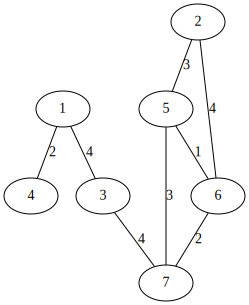

[1]
s: 1
succ: 3
[1, 3]
s: 3
succ: 1
s: 3
succ: 7
s==t: [1, 3, 7]
s: 1
succ: 4
1


In [12]:
#sol

def sol():
    # dijkstra and optimality principle or
    # bellman starting from the last node.
    pass

#

def generate_paths_dfs(G : Graph[T], prop : Callable[[T,T],bool], s : T, t : T, soFar : List[T] = [], mem : Dict[T,bool] = {}) -> int:
    
    soFar.append(s)
    if s == t:
        soFar.pop()
        return 1
    
    mem[s]  = True
    i : int = 0
    for w in G.succs(s):
        if  not ((w in mem) and mem[w]) and prop(s,w):
            i         += generate_paths_dfs(G,prop,w,t,soFar=soFar,mem=mem)
            mem[w]     = False
    
    soFar.pop()
    return i

g : Graph[int] = Graph(is_directed=False,is_weighted=True)
g.add_vertices([1,2,3,4,5,6,7])

costs : List[Tuple[int,int,float]] = [
    (1,3,4),(1,4,2),(3,7,4),(7,5,3),(7,6,2),
    (6,5,1),(6,2,4),(5,2,3)
 ]

costs_ : List[Tuple[int,int,float]] = [(1,2,3),(1,4,2),(1,3,3),(4,5,10),(2,3,1),(2,5,2),(3,5,1)]

g.add_cost_edges(costs)

display(g.toPic())




def minCost(v : int, w : int) -> bool:
    cost : List[float] = [4,2,1,6,0]
    cost               = [5,6,4,7,3,2,0]
    return cost[v-1] > cost[w-1]

print(generate_paths_dfs(g, minCost, 1,7))


# Largest Color Value in a Directed Graph

There is a **directed graph** of `n` colored nodes and `m` edges. The nodes are numbered from `0` to `n - 1`.

You are given a string `colors` where `colors[i]` is a lowercase English letter representing the **color** of the `ith` node in this graph (**0-indexed**). You are also given a 2D array `edges` where `edges[j] = [aj, bj]` indicates that there is a **directed edge** from node `aj` to node `bj`.

A valid **path** in the graph is a sequence of nodes `x1 -> x2 -> x3 -> ... -> xk` such that there is a directed edge from `xi` to `xi+1` for every `1 <= i < k`. The **color value** of the path is the number of nodes that are colored the **most frequently** occurring color along that path.

Return the **largest color value** of any valid path in the given graph, or `-1` if the graph contains a cycle.

In [ ]:
#sol